Velg hvilken statistikk du vil se:
1 - Gjennomsnittstemperatur per år
2 - Median og standardavvik
3 - Interaktivt inputår (fra-til)
4 - Korrelasjon mellom temperatur og tid (trend)


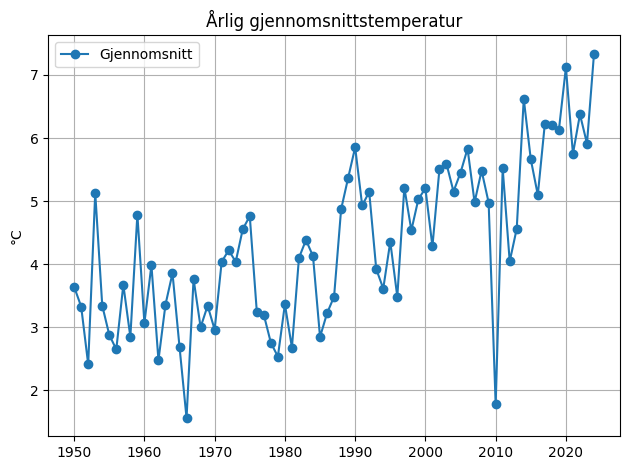

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openmeteo_requests
import requests_cache
from retry_requests import retry

# === API-setup ===
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# === API-forespørsel ===
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 63.43,
    "longitude": 10.39,
    "start_date": "1950-01-01",
    "end_date": "2024-12-31",
    "hourly": "temperature_2m"
}
responses = openmeteo.weather_api(url, params=params)
response = responses[0]

# === Prosesser responsen til DataFrame ===
hourly = response.Hourly()
temperature_2m = hourly.Variables(0).ValuesAsNumpy()
dates = pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)

df = pd.DataFrame({
    "date": dates,
    "temperature_2m": temperature_2m
})
df["year"] = df["date"].dt.year

# === Meny for analysevalg ===
print("Velg hvilken statistikk du vil se:")
print("1 - Gjennomsnittstemperatur per år")
print("2 - Median og standardavvik")
print("3 - Interaktivt inputår (fra-til)")
print("4 - Korrelasjon mellom temperatur og tid (trend)")
valg = input("Skriv tallet for ønsket analyse: ")

yearly = df.groupby("year")["temperature_2m"]

# === Statistikk ===
if valg == "1":
    avg = yearly.mean()
    plt.plot(avg.index, avg.values, marker='o', label="Gjennomsnitt")
    plt.title("Årlig gjennomsnittstemperatur")
    plt.ylabel("°C")
    plt.grid(True)

elif valg == "2":
    med = yearly.median()
    std = yearly.std()
    plt.plot(med.index, med.values, label="Median", linestyle="--", color="green")
    plt.plot(std.index, std.values, label="Standardavvik", linestyle=":", color="red")
    plt.title("Median og standardavvik")
    plt.grid(True)

elif valg == "3":
    start = int(input("Startår: "))
    end = int(input("Sluttår: "))
    subset = df[(df["year"] >= start) & (df["year"] <= end)]
    sns.lineplot(x="date", y="temperature_2m", data=subset)
    plt.title(f"Temperatur fra {start} til {end}")
    plt.xticks(rotation=45)

elif valg == "4":
    df["doy"] = df["date"].dt.dayofyear
    df["year_frac"] = df["date"].dt.year + df["doy"] / 365
    sns.regplot(x="year_frac", y="temperature_2m", data=df, scatter_kws={'s': 2}, line_kws={'color': 'red'})
    plt.title("Trend i temperatur over tid")
    plt.xlabel("År")
    plt.ylabel("°C")

else:
    print("Ugyldig valg.")
    exit()

plt.legend()
plt.tight_layout()
plt.show()
